# LLM Judgment - Human Judgment as a Target

This experiments applied the signed differecnes of LLM labels and human labels as a target for analysis the features.

In [2]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data

In [3]:
qrels = glob.glob(f'./qrels/*.txt')

In [4]:
qrels_df_list = []

for infile in qrels:
    judger = infile.split('/')[2].split('.')[3]
    result_df = pd.read_csv(infile, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'score'])
    result_df.drop(['Q0'], axis=1, inplace=True)
    result_df['judged_by'] = judger
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['score'] = result_df['score'].astype(int)
    qrels_df_list.append(result_df)
 
qrels_df = pd.concat(qrels_df_list)
qrels_df

,qid,docid,score,judged_by
0,2001010,msmarco_passage_00_257661787,0,withDupes
1,2001010,msmarco_passage_00_257662430,0,withDupes
2,2001010,msmarco_passage_00_257664103,0,withDupes
3,2001010,msmarco_passage_00_729310942,0,withDupes
4,2001010,msmarco_passage_00_729315698,1,withDupes
...,...,...,...,...
22322,3100922,msmarco_passage_61_425158788,1,gpt4
22323,3100922,msmarco_passage_64_139007780,0,gpt4
22324,3100922,msmarco_passage_67_28012312,0,gpt4
22325,3100922,msmarco_passage_67_95950055,0,gpt4


In [5]:
qid_to_info = pd.read_csv("infos/query_to_info.txt", sep='\t')
qrels_df = pd.merge(qrels_df, qid_to_info, on='qid')

In [6]:
qrels_df['judged_by'] = qrels_df['judged_by'].replace({'withDupes': 'Human', 'gpt4': 'GPT-4'})

In [7]:
# add a new column called 'QT' and the values are "Real" if Synthetic is 0 and isGPT is 0, "T5" if Synthetic is 1 and isGPT is 0, 
# "GPT-4" if Synthetic is 0 and isGPT is 1
qrels_df['QT'] = np.where((qrels_df['Synthetic'] == 0) & (qrels_df['isGPT4'] == 0), 'Real',
                          np.where((qrels_df['Synthetic'] == 1) & (qrels_df['isGPT4'] == 0), 'T5', 'GPT-4'))

/var/folders/y2/4_f9ys2n43x8fl_s39w55ytw0000gn/T/ipykernel_44605/3311959013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype('category')
/Users/saeed/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


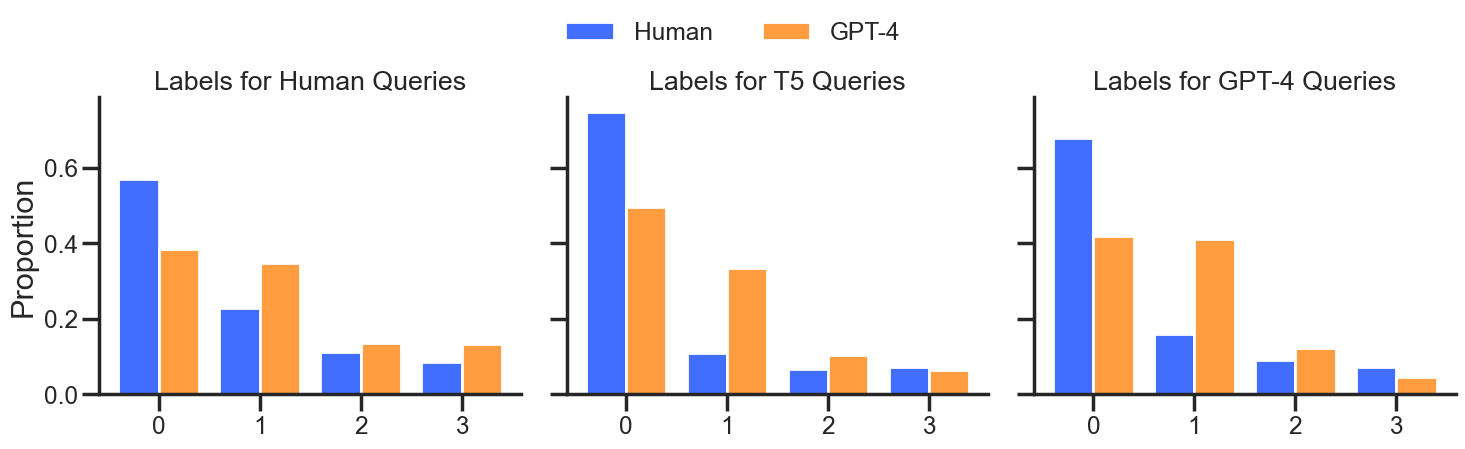

In [8]:
df = qrels_df[['score', 'judged_by', 'QW', 'QT']]
df['score'] = df['score'].astype('category')

sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_context("poster", font_scale =0.8)     # Options: paper, notebook, talk, poster
sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

# Create a FacetGrid for the label type
g = sns.FacetGrid(df, col="QT", hue="judged_by", height=5)

# Add a histogram to the FacetGrid
g.map(sns.histplot, 'score', stat="proportion", hue = 'judged_by', multiple='dodge', shrink = .8, common_norm=False, data = df)

# Adjust the titles and labels
g.add_legend()
g.set_axis_labels("", "Proportion", fontsize=22)
g.set_titles(col_template="{col_name}", fontsize=22)

titles = ['Labels for Human Queries', 'Labels for T5 Queries', 'Labels for GPT-4 Queries']

for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
    
sns.move_legend(g, ncol=3, loc='upper center', title = '')

# Adjust layout
plt.subplots_adjust(top=0.8)
# plt.legend(fontsize=19, ncol=2, loc='upper center')
# Show the plot
plt.xticks([0, 1, 2, 3])  # Set y-ticks to 0, 1, 2, 3
plt.savefig("figs/label_barplots.pdf", bbox_inches="tight")